* [uci-secom.csv] : https://www.kaggle.com/paresh2047/uci-semcom

#Part4. [실습6] 반도체 제조 공정 프로세스 Pass_Fail 수율 예측

* matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

In [ ]:
# import matplotlib.pyplot as plt

# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# import matplotlib.font_manager as fm

# path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# plt.rc('font', family=font_name)

# fm._rebuild()

In [ ]:
from matplotlib import pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

## 01. 데이터 소개 및 분석프로세스 수립
 : "강의자료 → Ch04. [실습6] 반도체 제조 공정 프로세스 Pass_Fail 수율 예측" 참고

## 02. 데이터 준비를 위한 EDA 및 전처리

### 0. 데이터 불러오기

In [ ]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/강의/실습자료/data/ch8/uci-secom.csv')
data.head()

,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,...,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,NaN,NaN,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,87.5241,...,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,2.0295,7.5788,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,84.7327,...,0.85,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,1.5021,0.3718,0.1233,24.7524,267.064,0.9032,1.10,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.0584,0.0484,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,-0.0033,0.9629,201.8482,0.0,9.6052,422.2894,9.6924,0.9687,192.1557,12.4782,1.4011,-5468.25,2648.25,-4515.00,-1657.25,1.3137,2.0038,7.3145,62.9333,2.6444,0.2071,3.3813,84.9105,8.6789,50.5100,64.1125,49.4900,65.1951,86.6867,...,39.33,0.6812,56.9303,17.4781,161.4081,35.3198,54.2917,1.1613,0.7288,0.2710,62.7572,268.228,0.6511,7.32,0.1630,3.5611,0.0670,2.7290,25.0363,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0.0202,0.0149,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,-0.0072,0.9569,201.9424,0.0,10.5661,420.5925,10.3387,0.9735,191.6037,12.4735,1.3888,-5476.25,2635.25,-3987.50,117.00,1.2887,1.9912,7.2748,62.8333,3.1556,0.2696,3.2728,86.3269,8.7677,50.2480,64.1511,49.7520,66.1542,86.1468,...,1.98,0.4287,9.7608,0.8311,70.9706,4.9086,2.5014,0.9778,0.2156,0.0461,22.0500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,NaN,NaN,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [ ]:
# 데이터의 모양 알아보기
data.shape

(1567, 592)

### 1. 데이터 탐색



#### 1) 데이터 타입

In [ ]:
# 컬럼별 데이터 타입 알아보기
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


#### 2) 데이터 통계값

In [ ]:
# 컬럼별 간단한 통계값 보기
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1564.0,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1557.000000,1567.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,...,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1566.000000,1566.000000,1566.000000,1566.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,618.000000,618.000000,618.000000,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,0.000146,0.964353,199.956809,0.0,9.005371,413.086035,9.907603,0.971444,190.047354,12.481034,1.405054,-5618.393610,2699.378435,-3806.299734,-298.598136,1.203845,1.938477,6.638628,69.499532,2.366197,0.184159,3.673189,85.337469,8.960279,50.582639,64.555787,49.417370,66.221274,86.836577,118.679554,...,1.230712,0.276688,7.703874,0.503657,57.746537,4.216905,1.623070,0.995009,0.325708,0.072443,32.284956,262.729683,0.679641,6.444985,0.145610,2.610870,0.060086,2.452417,21.117674,530.523623,2.101836,28.450165,0.345636,9.162315,0.104729,5.563747,16.642363,0.021615,0.016829,0.005396,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,0.009302,0.012452,3.257276,0.0,2.796596,17.221095,2.403867,0.012062,2.781041,0.217965,0.016737,626.822178,295.498535,1380.162148,2902.690117,0.177600,0.189495,1.244249,3.461181,0.408694,0.032944,0.535322,2.026549,1.344456,1.182618,2.574749,1.182619,0.304141,0.446756,1.807221,...,1.361117,0.276231,2.192647,0.598852,35.207552,1.280008,1.870433,0.083860,0.201392,0.051578,19.026081,7.630585,0.121758,2.633583,0.081122,1.032761,0.032761,0.996644,10.213294,17.499736,0.275112,86.304681,0.248478,26.920150,0.067791,16.921369,12.485267,0.011730,0.009640,0.003116,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,-0.034900,0.655400,182.094000,0.0,2.249300,333.448600,4.469600,0.579400,169.177400,9.877300,1.179700,-7150.250000,0.000000,-9986.750000,-14804.500000,0.000000,0.000000,0.000000,59.400000,0.666700,0.034100,2.069800,83.182900,7.603200,49.834800,63.677400,40.228900,64.919300,84.732700,111.712800,...,0.120000,0.018700,2.786000,0.052000,4.826900,1.496700,0.164600,0.891900,0.069900,0.017700,7.236900,242.286000,0.304900,0.970000,0.022400,0.412200,0.009100,0.370600,3.250400,317.196400,0.980200,3.540000,0.066700,1.039500,0.023000,0.663600,4.582000,-0.016900,0.003200,0.001000,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,-0.005600,0.958100,198.130700,0.0,7.094875,406.127400,9.567625,0.968200,188.299825,12.460000,1.396500,-5933.250000,2578.000000,-4371.750000,-1476.000000,1.094800,1.906500,5.263700,67.377800,2.088900,0.161700,3.362700,84.490500,8.580000,50.252350,64.024800,49.421200,66.040650,86.578300,118.015600,...,0.870000,0.094900,6.738100,0.343800,27.017600,3.625100,1.182900,0.9

#### 3) 결측값

In [ ]:
data.isnull().any().any()

True

#### 4) 중복값

In [ ]:
# 중복된 항목 수 알아보기
print("중복된 항목 수 :", len(data[data.duplicated()])) 

중복된 항목 수 : 0


### 2. 데이터 전처리

#### 1. 결측값 채우기

In [ ]:
# NaN 을 0으로 채우기
data = data.replace(np.NaN, 0)

# 결측값 확인
data.isnull().any().any()

False

### 3. Target Feature 정의



#### 1) 데이터 탐색

In [ ]:
data['Pass/Fail'].unique()

array([-1,  1])

> Pie Chart

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


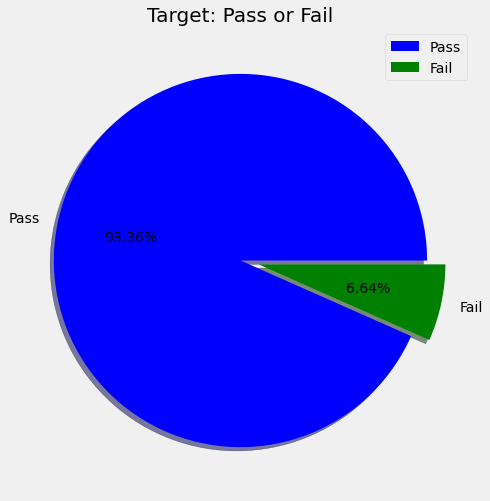

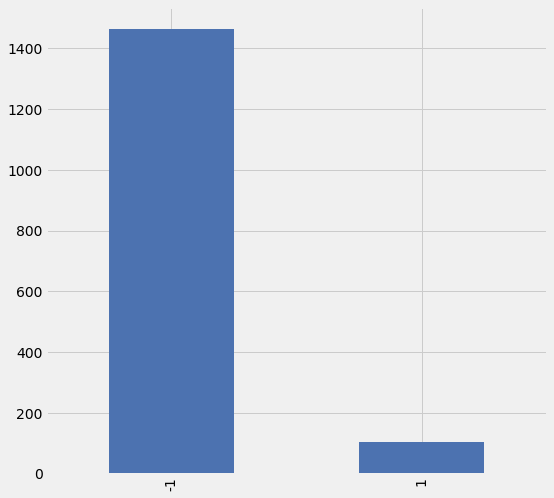

In [ ]:
labels = ['Pass', 'Fail']
size = data['Pass/Fail'].value_counts()
colors = ['blue', 'green']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
data['Pass/Fail'].value_counts().plot(kind="bar");

* 매우 불균형한 데이터

#### 2) 각 센서별 Target Feature 분포

In [ ]:
unique_vals = data['Pass/Fail'].unique()
targets = [data.loc[data['Pass/Fail'] == val] for val in unique_vals]

In [ ]:
targets

[                     Time        0        1  ...     588       589  Pass/Fail
 0     2008-07-19 11:55:00  3030.93  2564.00  ...  0.0000    0.0000         -1
 1     2008-07-19 12:32:00  3095.78  2465.14  ...  0.0060  208.2045         -1
 3     2008-07-19 14:43:00  2988.72  2479.90  ...  0.0044   73.8432         -1
 4     2008-07-19 15:22:00  3032.24  2502.87  ...  0.0044   73.8432         -1
 5     2008-07-19 17:53:00  2946.25  2432.84  ...  0.0052   44.0077         -1
 ...                   ...      ...      ...  ...     ...       ...        ...
 1562  2008-10-16 15:13:00  2899.41  2464.36  ...  0.0047  203.1720         -1
 1563  2008-10-16 20:49:00  3052.31  2522.55  ...  0.0047  203.1720         -1
 1564  2008-10-17 05:26:00  2978.81  2379.78  ...  0.0025   43.5231         -1
 1565  2008-10-17 06:01:00  2894.92  2532.01  ...  0.0075   93.4941         -1
 1566  2008-10-17 06:07:00  2944.92  2450.76  ...  0.0045  137.7844         -1
 
 [1463 rows x 592 columns],
                      

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2056

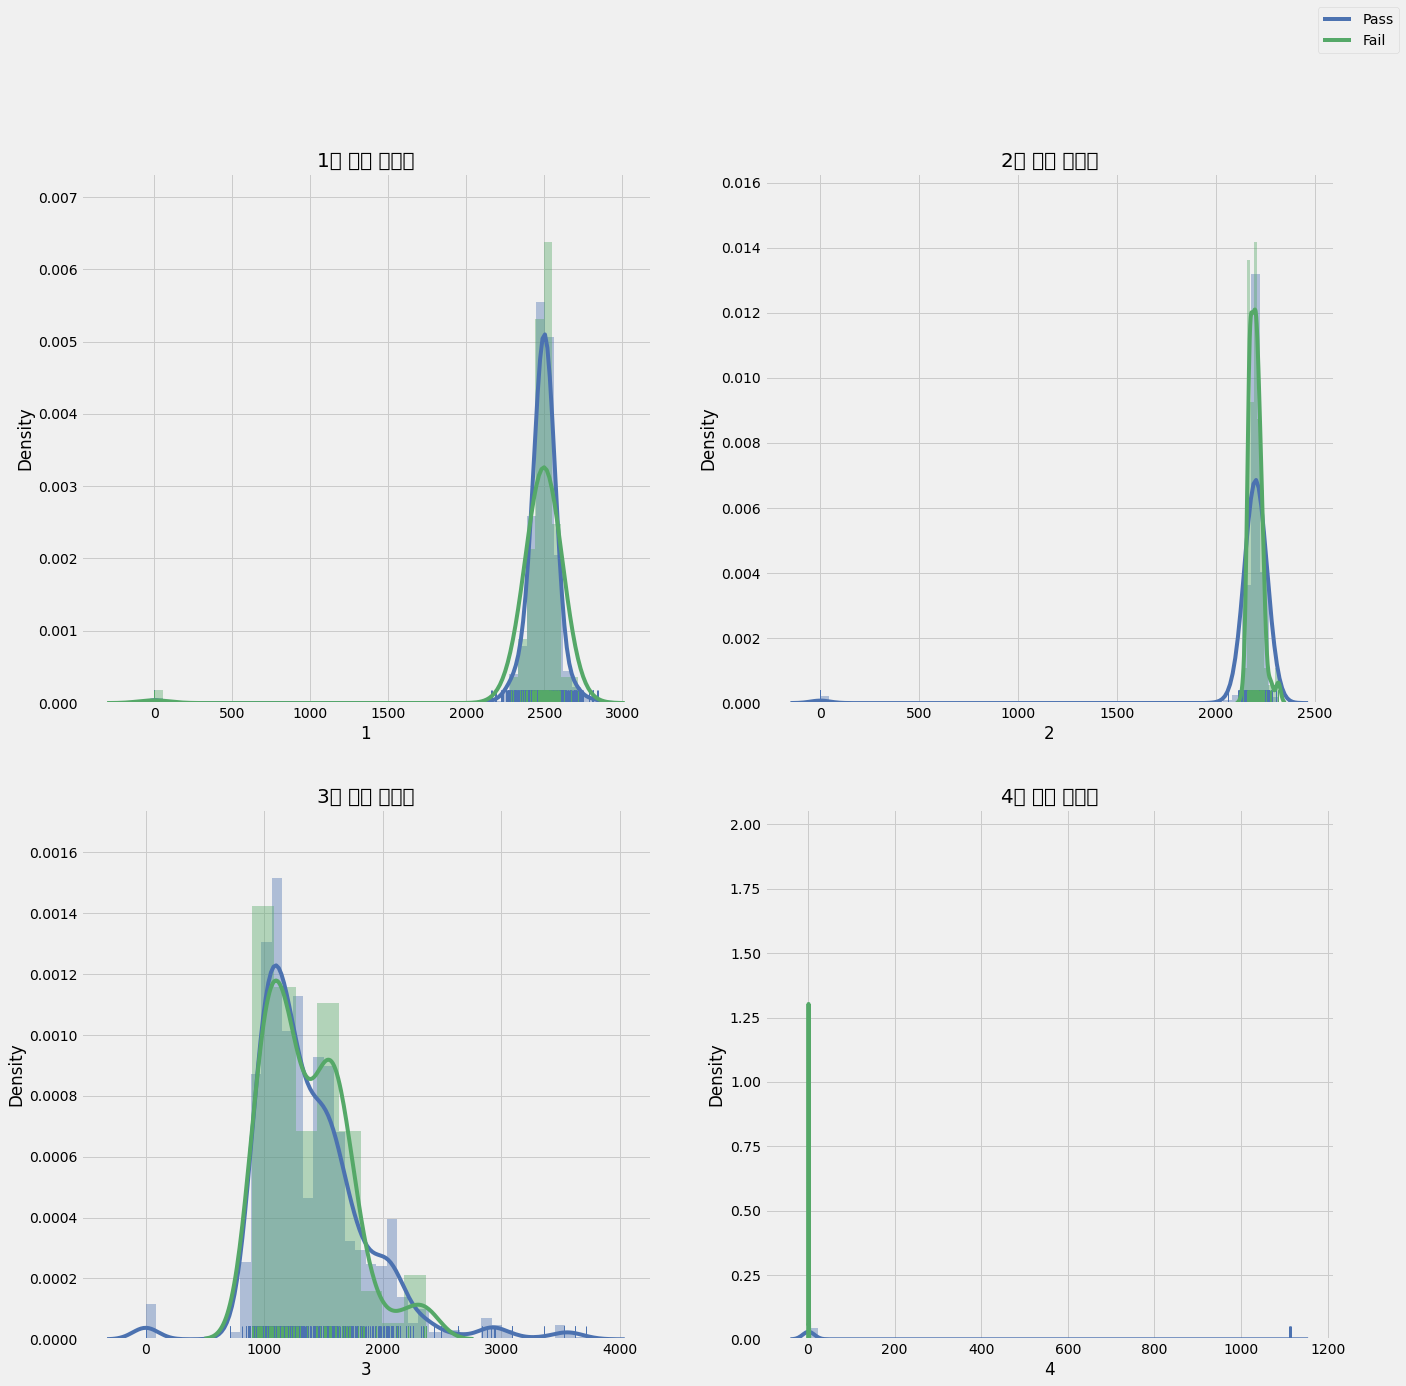

In [ ]:
fig = plt.figure(figsize=(20,20))

plt.subplot(2, 2, 1)
for target in targets:
    sns.distplot(target['1'], hist=True, rug=True)
plt.title('1번 센서 계측값', fontsize = 20)

plt.subplot(2, 2, 2)
for target in targets:
    sns.distplot(target['2'], hist=True, rug=True)
plt.title('2번 센서 계측값', fontsize = 20)

plt.subplot(2, 2, 3)
for target in targets:
    sns.distplot(target['3'], hist=True, rug=True)
plt.title('3번 센서 계측값', fontsize = 20)

plt.subplot(2, 2, 4)
for target in targets:
    sns.distplot(target['4'], hist=True, rug=True)
plt.title('4번 센서 계측값', fontsize = 20)

#sns.add_legend()
#plt.legend()
fig.legend(labels=['Pass','Fail'])
plt.show()

### 4. 상관성에 따른 Feature 정제

#### 1) 히트맵 확인

Text(0.5, 1.0, '상관 히트맵')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47605 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_

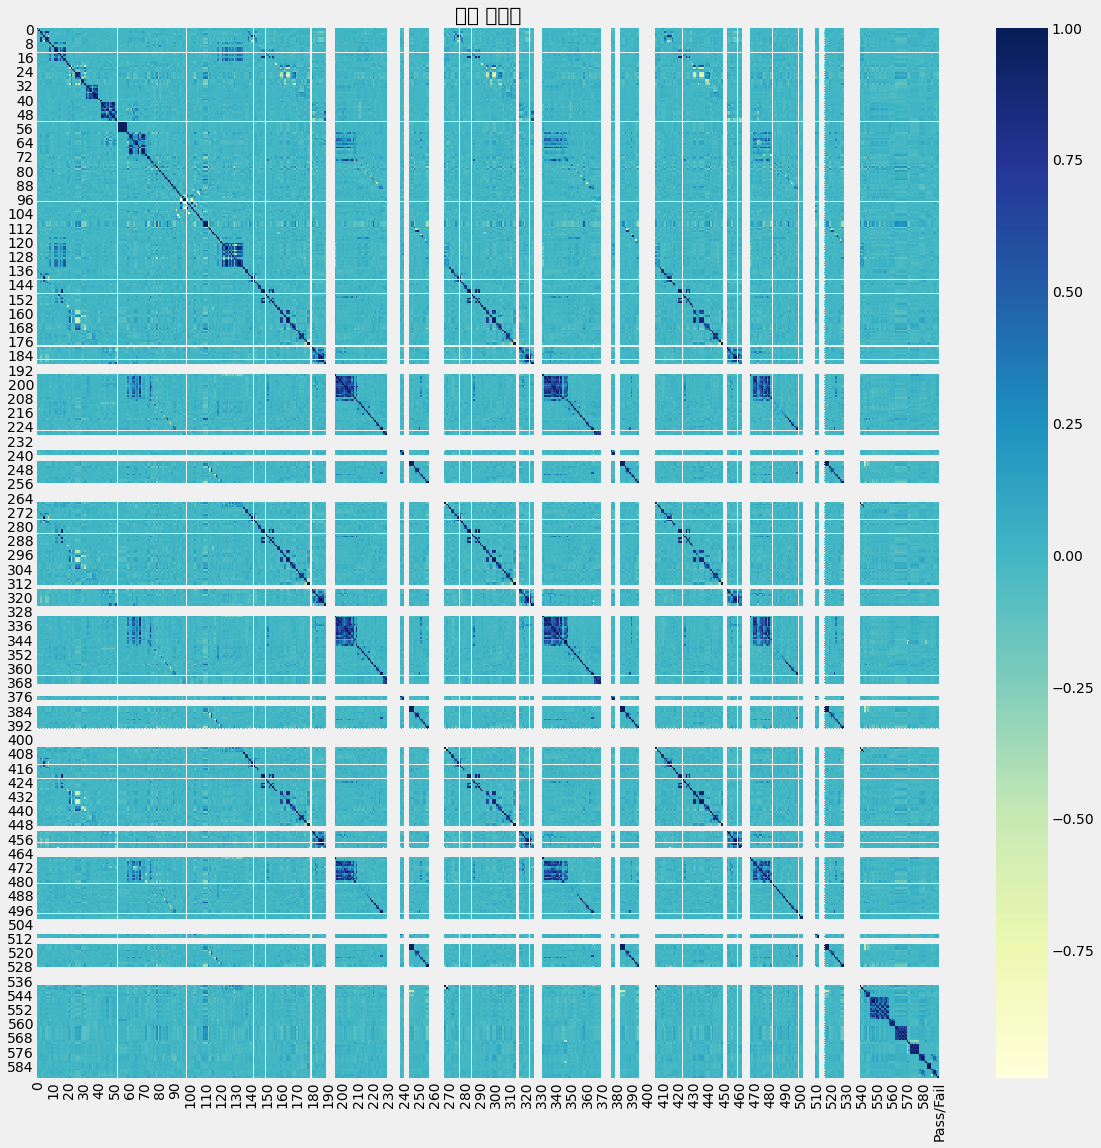

In [ ]:
plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(data.corr(), cmap = "YlGnBu")
plt.title('상관 히트맵', fontsize = 20)

#### 2) 상관계수

##### 상관계수 필터링 함수

> 입력한 상관계수 threshold 에 따라 Feature 들 필터링하는 함수 정의

In [ ]:
# 상관계수 구하기
data.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
0,1.000000,-0.047782,0.007590,0.009448,-0.000915,0.008706,0.006129,0.010738,-0.050979,0.009959,-0.010253,0.013038,0.021365,NaN,-0.058009,0.013962,-0.002250,0.012261,0.023585,0.010113,-0.007342,-0.025226,0.027996,-0.007591,-0.016491,0.011886,0.020927,0.012133,0.060231,0.001072,-0.022881,0.009555,0.000576,-0.004361,0.003312,0.006871,-0.002194,0.000013,-0.009836,0.004458,...,-0.021009,-0.069946,-0.055481,-0.021497,-0.020062,-0.054211,-0.018304,0.006976,0.031143,0.032186,0.027226,0.008795,0.001255,0.028746,0.026128,0.030097,0.023653,0.026880,0.030230,-0.019543,-0.018934,0.018681,0.011117,0.019126,0.012574,0.018709,0.017193,-0.041694,-0.039881,-0.041868,-0.033622,0.010503,0.019840,0.017889,0.019522,0.044745,0.005233,0.003918,0.021489,0.006149
1,-0.047782,1.000000,-0.030448,0.006021,0.002192,-0.030127,-0.031616,-0.025086,0.027609,0.003704,0.028889,0.009722,0.008212,NaN,0.017214,-0.000023,0.002047,0.023212,0.019432,-0.007581,0.050178,0.020399,-0.018847,-0.026097,-0.074160,-0.022150,-0.022685,-0.015609,-0.005010,-0.025961,-0.004717,-0.010433,-0.016228,-0.004064,-0.014994,-0.017616,0.011899,0.000332,-0.001337,-0.012124,...,0.006085,-0.028195,-0.007203,0.008259,-0.026061,-0.009124,0.005462,-0.031798,-0.012725,0.003041,-0.013670,0.014554,0.015110,-0.002717,0.013126,-0.004402,0.013645,-0.003912,0.014674,-0.005541,-0.027022,0.015385,-0.004580,0.015353,-0.002177,0.015897,-0.001023,0.013738,0.039350,0.039974,0.043107,-0.017392,0.003809,0.004409,0.003821,-0.009219,0.039479,0.040500,0.044464,-0.019672
2,0.007590,-0.030448,1.000000,0.323782,0.020438,0.990089,0.818770,0.747230,0.002600,-0.045731,0.004713,-0.011469,-0.010719,NaN,-0.012309,-0.009343,0.005165,-0.002888,-0.013282,0.025736,0.006447,0.001081,-0.008963,0.042508,-0.011340,-0.027246,-0.024152,-0.027503,-0.042699,0.006223,0.013223,0.015232,0.003556,0.001566,0.001788,0.010744,-0.011426,0.003493,0.003718,-0.015727,...,0.013323,0.044196,0.017413,0.012897,0.051356,0.015957,0.011752,0.026577,0.012112,0.013518,0.009676,-0.045425,-0.072819,-0.056225,-0.052832,-0.056457,-0.055573,-0.055480,-0.032925,-0.014631,0.040179,0.021562,0.019924,0.022026,0.017472,0.022311,0.014907,0.043303,0.040090,0.034312,0.038416,-0.010627,-0.004771,-0.003030,-0.004263,0.015733,-0.007090,-0.009122,-0.030434,0.024929
3,0.009448,0.006021,0.323782,1.000000,-0.054015,0.286397,-0.119180,0.279646,-0.108217,0.051567,0.046281,-0.035772,-0.058282,NaN,-0.026669,-0.032513,-0.007943,-0.017460,-0.040251,0.000716,0.037538,0.009006,-0.022624,0.001474,-0.050055,0.074149,0.036573,0.078740,0.082009,-0.006764,0.008643,-0.089499,-0.007227,-0.035723,0.001030,0.051171,0.005532,0.007167,-0.002897,0.011559,...,-0.000863,-0.017200,0.024084,-0.005045,-0.009816,0.027088,0.000902,0.076466,0.026239,0.015234,0.015142,0.078750,0.052595,0.053740,0.059957,0.054835,0.061671,0.052270,0.080510,-0.000589,-0.004817,0.013573,0.019621,0.012853,0.013097,0.014220,0.021228,0.072474,0.033122,0.036409,0.000922,0.009788,0.022593,0.022361,0.023288,0.038755,-0.038371,-0.033648,-0.084449,-0.016341
4,-0.000915,0.002192,0.020438,-0.054015,1.000000,0.007041,-0.034736,-0.475861,-0.020082,0.053859,-0.006505,0.001362,0.000526,NaN,-0.017112,0.009547,-0.001273,0.002358,0.001656,0.005752,0.012833,0.007304,-0.006797,0.005040,-0.013702,0.027770,0.010972,0.028338,0.007223,-0.012178,0.002324,-0.033636,-0.002867,0.012276,0.002324,-0.004535,-0.000681,0.002111,-0.002007,0.007056,...,-0.003883,-0.005514,0.016586,-0.005371,-0.005496,0.021616,-0.002388,-0.022981,-0.026991,-0.028717,-0.025685,0.026498,0.034501,0.009080,0.046680,0.006548,0.043524,0.007719,0.036344,0.005206,-0.081680,-0.011870,-0.016361,-0.012109,-0.017724,-0.012007,-0.003936,0.008852,0.022099,0.025856,0.107783,0.012778,-0.001323,-0.001605,-0.0016

In [ ]:
def remove_collinear_features(x, threshold):
    # 데이터프레임 x 의 상관계수 구하기
    corr_matrix = x.corr()
    # Pass / Fail 을 제외한 컬럼수
    iters = range(len(corr_matrix.columns) - 1)
    # 제거할 컬럼들 저장할 리스트
    drop_cols = []

    for i in iters:
        for j in range(i+1):

            # j행 (i+1)열 상관계수 가져오기
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            # 상관계수 셀의 컬럼명 가져오기
            col = item.columns
            # 상관계수 셀의 행 인덱스 가져오기
            row = item.index
            # 상관계수의 절대값
            val = abs(item.values)

            if val >= threshold:
                print(col.values[0], "열", row.values[0], "행의 상관계수 : ", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [ ]:
threshold = 0.70
data = remove_collinear_features(data,threshold)

5 열 2 행의 상관계수 :  0.99
6 열 2 행의 상관계수 :  0.82
6 열 5 행의 상관계수 :  0.84
7 열 2 행의 상관계수 :  0.75
7 열 5 행의 상관계수 :  0.77
12 열 11 행의 상관계수 :  0.83
17 열 11 행의 상관계수 :  0.81
18 열 11 행의 상관계수 :  0.72
18 열 12 행의 상관계수 :  0.79
18 열 17 행의 상관계수 :  0.9
22 열 21 행의 상관계수 :  0.75
26 열 25 행의 상관계수 :  0.83
27 열 25 행의 상관계수 :  0.98
27 열 26 행의 상관계수 :  0.79
30 열 29 행의 상관계수 :  0.86
34 열 32 행의 상관계수 :  0.88
35 열 34 행의 상관계수 :  0.83
37 열 32 행의 상관계수 :  0.75
37 열 34 행의 상관계수 :  0.75
38 열 32 행의 상관계수 :  0.72
38 열 34 행의 상관계수 :  0.72
38 열 36 행의 상관계수 :  0.71
38 열 37 행의 상관계수 :  0.97
39 열 32 행의 상관계수 :  0.81
39 열 34 행의 상관계수 :  0.91
39 열 35 행의 상관계수 :  0.71
39 열 37 행의 상관계수 :  0.86
39 열 38 행의 상관계수 :  0.84
43 열 42 행의 상관계수 :  0.82
44 열 42 행의 상관계수 :  0.82
46 열 42 행의 상관계수 :  0.84
46 열 43 행의 상관계수 :  0.84
46 열 45 행의 상관계수 :  0.74
48 열 44 행의 상관계수 :  0.77
49 열 42 행의 상관계수 :  1.0
49 열 43 행의 상관계수 :  0.82
49 열 44 행의 상관계수 :  0.82
49 열 46 행의 상관계수 :  0.84
50 열 42 행의 상관계수 :  0.88
50 열 43 행의 상관계수 :  0.9
50 열 46 행의 상관계수 :  0.97
50 열 49 행의 상관계수 :  0.88
51 열 

#### 3) 머신러닝 모델 입력 데이터 생성

In [ ]:
# Time 컬럼 삭제
data = data.drop(columns = ['Time'], axis = 1)

In [ ]:
data.shape

(1567, 307)

In [ ]:
data.head()

,0,1,2,3,4,8,9,10,11,13,14,15,16,19,20,21,23,24,25,28,29,31,32,33,36,40,41,42,45,47,52,53,59,60,62,63,64,67,71,72,...,507,508,509,510,511,512,513,514,515,521,528,529,530,531,532,533,534,535,536,537,538,542,543,544,546,551,558,559,562,565,570,571,572,578,582,583,586,587,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,1.5005,0.0162,-0.0034,0.9455,0.0,7.9558,414.8710,10.0433,12.5190,1.4026,-5419.00,-4043.75,751.00,0.8955,64.2333,2.0222,3.5191,83.3971,9.5126,49.3830,61.29,4.515,70.0,130.3691,1.3072,0.0,4.592,-1.7264,350.9264,108.6427,16.1445,21.7264,0.9226,84.0793,0.0000,...,0.0,0.0,0.0,64.6707,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1096,0.0078,0.0026,1.0616,0.78,1.0344,0.4385,0.000,0.0000,533.8500,2.1113,8.95,0.0000,0.5005,0.0118,0.0000,0.0000,0.0000,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,1.4966,-0.0005,-0.0148,0.9627,0.0,10.1548,414.7347,9.2599,12.4608,1.3825,-5441.50,-3498.75,-1640.25,1.2973,68.4222,2.2667,3.4171,84.9052,9.7997,49.3404,78.25,2.773,70.0,133.1727,1.2887,0.0,4.590,0.8073,352.0073,113.9800,10.9036,19.1927,1.1598,82.3494,0.0000,...,0.0,0.0,0.0,141.4365,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1096,0.0078,0.0026,1.3526,1.33,0.9634,0.1745,0.000,0.0000,535.0164,2.4335,5.92,0.0096,0.5019,0.0223,0.0096,0.0201,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,1.4436,0.0041,0.0013,0.9615,0.0,9.5157,416.7075,9.3144,12.5404,1.4123,-5447.75,-4047.00,-1916.50,1.3122,67.1333,2.3333,3.5986,84.7569,8.6590,49.8470,14.37,5.434,70.0,131.8027,1.2992,0.0,4.486,23.8245,364.5364,115.6273,11.3019,16.1755,0.8694,84.7681,140.6972,...,0.0,0.0,0.0,240.7767,244.2748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1096,0.0078,0.0026,0.7942,0.85,1.5021,0.3718,267.064,0.6219,535.0245,2.0293,11.21,0.0584,0.4958,0.0157,0.0584,0.0484,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,1.4882,-0.0124,-0.0033,0.9629,0.0,9.6052,422.2894,9.6924,12.4782,1.4011,-5468.25,-4515.00,-1657.25,1.3137,62.9333,2.6444,3.3813,84.9105,8.6789,49.4900,76.90,1.279,70.0,131.8027,1.3027,0.0,4.486,24.3791,361.4582,116.1818,13.5597,15.6209,0.9761,70.2289,160.3210,...,0.0,0.0,0.0,113.5593,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1096,0.0078,0.0026,1.1650,39.33,1.1613,0.7288,268.228,0.1630,530.5682,2.0253,9.33,0.0202,0.4990,0.0103,0.0202,0.0149,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,1.5031,-0.0031,-0.0072,0.9569,0.0,10.5661,420.5925,10.3387,12.4735,1.3888,-5476.25,-3987.50,117.00,1.2887,62.8333,3.1556,3.2728,86.3269,8.7677,49.7520,76.39,2.209,70.0,176.3136,1.0341,0.0,4.624,-12.2945,355.0809,144.0191,21.9782,32.2945,0.9256,65.8417,0.0000,...,0.0,0.0,0.0,148.0663,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1096,0.0078,0.0026,1.4636,1.98,0.9778,0.2156,0.000,0.0000,532.0155,2.0275,8.83,0.0000,0.4800,0.4766,0.0202,0.0149,73.8432,-1


### 5. Target Feature 불균형 문제 처리

#### 1. UnderSampling

> 데이터 탐색

In [ ]:
failed_tests = np.array(data[data['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

104


In [ ]:
normal_indices = data[data['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

1463


In [ ]:
# Pass 라벨(값이 1)에서 랜덤으로 104개 가져오기
random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

104


In [ ]:
# 같은 비율로 합친 Pass/Fail 데이터 생성
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [ ]:
undersample_data = data.iloc[under_sample, :]

In [ ]:
x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(208, 306)
(208, 1)


In [ ]:
# 언더샘플링 데이터 훈련/테스트 데이터 분할
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(145, 306)
(145, 1)
(63, 306)
(63, 1)


In [ ]:
# StandardScaler 적용
sc = StandardScaler()
x_train_us = sc.fit_transform(x_train_us)
x_test_us = sc.transform(x_test_us)

#### 2. OverSampling using SMOTE

In [ ]:
# SMOTE 적용
x_resample, y_resample  = SMOTE(random_state=1).fit_sample(x, y.values.ravel())

print(x_resample.shape)
print(y_resample.shape)

(222, 306)
(222,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_os.shape)
print(y_train_os.shape)
print(x_test_os.shape)
print(y_test_os.shape)

(145, 306)
(145, 1)
(63, 306)
(63, 1)


In [ ]:
# standardScale 적용
sc = StandardScaler()
x_train_os = sc.fit_transform(x_train_os)
x_test_os = sc.transform(x_test_os)

## 03. 머신러닝 모델링

### 1) 데이터 준비

In [ ]:
x = data.iloc[:,:(data.shape[1]-1)]
y = data["Pass/Fail"]

print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 306)
shape of y: (1567,)


In [ ]:
# 훈련/테스트 데이터 세트 나누기
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (1096, 306)
shape of x_test:  (471, 306)
shape of y_train:  (1096,)
shape of y_test:  (471,)


### 2) 다양한 Classifier 와 Grid Search 를 활용한 최적 모델 탐색



#### 1. Feature Scailing

In [ ]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 선언
sc = StandardScaler()
# StandardScaler 에 fit_transform
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

#### 2. XGBoost (Scaled 데이터)

In [ ]:
xg = XGBClassifier(random_state=1)
xg.fit(x_train, y_train)
y_pred = xg.predict(x_test)

> Confusion Matrix 

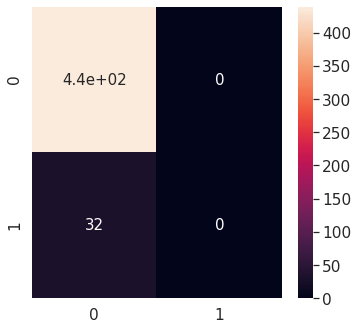

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [ ]:
print("Accuracy: ", xg.score(x_test,y_test)*100)

Accuracy:  93.20594479830149


#### 3. RandomForest (Scaled 데이터)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

> Confusion Matrix 

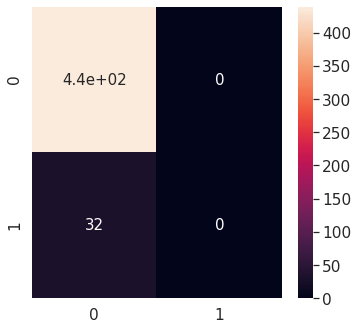

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [ ]:
print("Accuracy: ", rf.score(x_test,y_test)*100)

Accuracy:  93.20594479830149


#### 4. Logistic Regression (Scaled 데이터)

In [ ]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train, y_train) 
y_pred = lr.predict(x_test)

> Confusion Matrix 

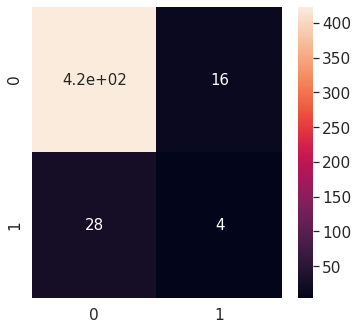

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [ ]:
print("Accuracy: ", lr.score(x_test,y_test)*100)

Accuracy:  90.65817409766454


#### 5. Lasso (Scaled 데이터)

In [ ]:
lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train,y_train)
y_pred = lasso.predict(x_test)

In [ ]:
# 예측값의 부호를 classifier 로 변환
y_pred2 = np.sign(y_pred)

In [ ]:
print("Accuracy: ", lasso.score(x_test,y_test)*100)

Accuracy:  -0.007974076019068299


> Confusion Matrix 

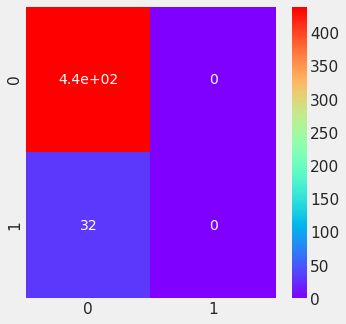

In [ ]:
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

### 3) 언더샘플링 데이터 대상 재모델링

#### 1. XGBoost (Undersampled 데이터)

In [ ]:
model = XGBClassifier(random_state=1)
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


> Confusion Matrix 

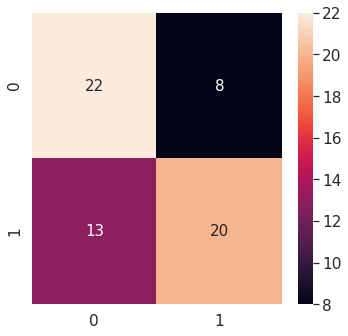

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [ ]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  39.91507430997877


#### 2. Grid Search - XGBoost (Undersampled 데이터)

In [ ]:
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy',  n_jobs = -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print("Best Accuracy: ", best_accuracy*100)
print("Best Parameter: ", best_parameters)

Best Accuracy:  67.58620689655173
Best Parameter:  {'cv': 2, 'max_depth': 3, 'random_state': 1}


In [ ]:
# scale_pos_weights 사용
weights = (y == 0).sum()/(1.0*(y == -1).sum())

model = XGBClassifier(max_depth = 3, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  39.91507430997877


> Confusion Matrix 

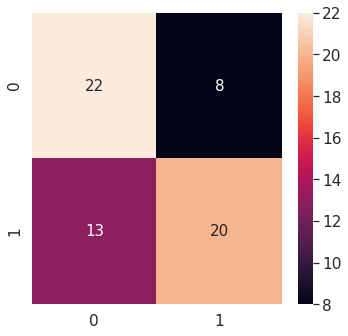

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

#### 2. Random Forest (Undersampled 데이터)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


> Confusion Matrix

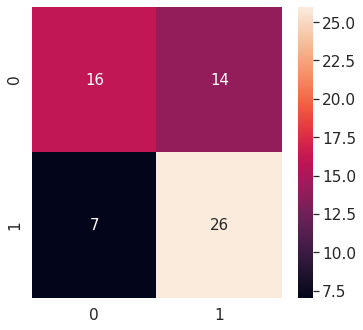

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [ ]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  36.09341825902335


#### 3. Logistic Regression (Undersampled 데이터)

In [ ]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_us, y_train_us)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = lr.predict(x_test_us)

**Confusion matrix for Logistic Regression (Undersampled)**

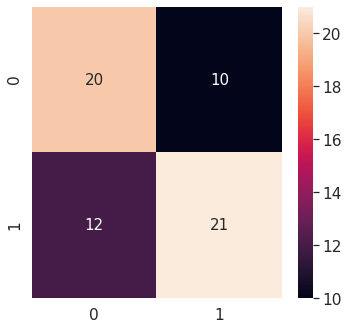

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [ ]:
print("Accuracy: ", lr.score(x_test,y_test)*100)

Accuracy:  48.40764331210191


#### 4. Lasso (Undersampled 데이터)

In [ ]:
lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train_us,y_train_us)
#print ("Lasso model:", (lasso.coef_))

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
y_pred = lasso.predict(x_test_us)

In [ ]:
print(y_pred)

[-3.24391394e-02 -6.72334266e+00  5.78318220e-01  3.70274970e-01
 -5.48634758e-02  2.32969442e-01 -8.99114593e-02  5.98606858e-01
 -1.58540227e-01 -4.03466243e-01  6.94186181e-01 -1.37514032e-01
 -6.32337202e-02 -4.90027269e-02 -4.03466243e-01  4.74760759e-02
 -7.13435761e-02  8.01084395e-03  6.68327077e-01  1.86204884e-01
  1.70181832e-01  7.66173088e-02  1.00514841e-01  9.25429434e-01
 -3.75027534e-01 -1.21304082e-01  4.51256569e-02  2.92859342e-01
  2.36418480e-01 -3.03588305e-01 -3.06672673e-01  1.86059856e-01
  2.96323788e-01  6.59690183e-01 -6.88688603e-02  2.68642302e-01
  2.50090848e-01  5.67011347e-01 -8.85087228e-03 -2.79740850e-01
 -1.86904383e-01  1.24130149e-01  1.48565469e-01  1.58261281e-01
  1.26844264e-01  3.35480221e-02  1.77460794e-01  1.57485599e-01
  8.89765995e-02 -3.59447872e-01  3.98098924e-03 -3.61595589e-01
 -2.19789859e-01  5.78354056e-01  6.67228163e-01  1.37127211e-02
  4.72917110e-01 -3.03963034e-01  7.02926186e-03  1.10108082e-01
  1.18316266e-03  5.23737

In [ ]:
print(y_test_us)

      Pass/Fail
1287         -1
426          -1
159          -1
60           -1
495           1
...         ...
1302          1
273           1
807          -1
106          -1
441           1

[63 rows x 1 columns]


In [ ]:
y_pred2 = np.sign(y_pred)

> Confusion Matrix

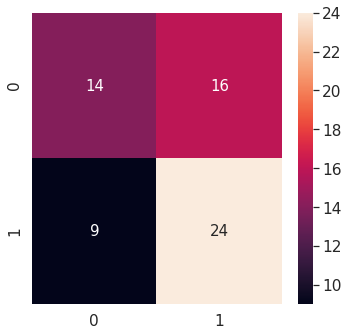

In [ ]:
cm = confusion_matrix(y_test_us, y_pred2)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [ ]:
print("Accuracy: ", lasso.score(x_test_us,y_test_us)*100)

Accuracy:  -42.69915729215064


### 4) 오버샘플링 데이터 대상 재모델링

#### 1. Grid Search - XGBoost (Oversampled 데이터)

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=1)
model.fit(x_train_os, y_train_os)
y_pred = model.predict(x_test_os)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', n_jobs = -1)
grid_search = grid_search.fit(x_train_os, y_train_os)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print("Best Accuracy: ", best_accuracy)
print("Best Parameter: ", best_parameters)

Best Accuracy:  0.6758620689655173
Best Parameter:  {'cv': 2, 'max_depth': 3, 'random_state': 1}


In [ ]:
weights = (y == 0).sum()/(1.0*(y == -1).sum())

model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)
model.fit(x_train_os, y_train_os)
y_pred = model.predict(x_test_os)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


> Confusion Matrix

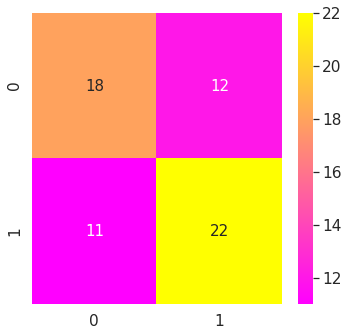

In [ ]:
cm = confusion_matrix(y_test_os, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15}, cmap = 'spring')

In [ ]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  34.182590233545646


#### 2. Random Forest (Oversampled 데이터)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_os, y_train_os)
y_pred = model.predict(x_test_os)
print("Accuracy: ", model.score(x_test_os,y_test_os)*100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy:  66.66666666666666


> Confusion Matrix

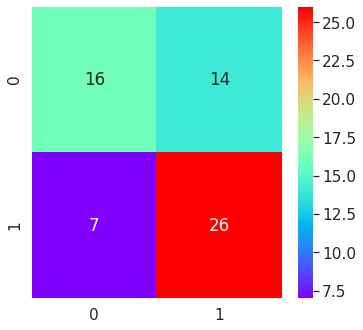

In [ ]:
# printing the confusion matrix
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

#### 3. Logistic Regression (Oversampled 데이터)

In [ ]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_os, y_train_os) 
y_pred = lr.predict(x_test_os)

print("Accuracy: ", lr.score(x_test_os,y_test_os)*100)

Accuracy:  65.07936507936508


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


> Confusion Matrix

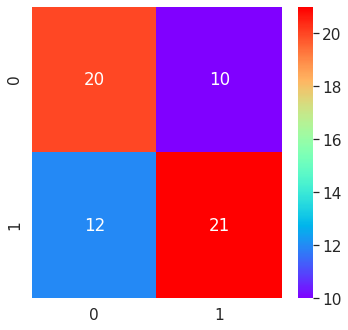

In [ ]:
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

### 5) PCA 를 활용한 차원 축소

In [ ]:
data.shape

(1567, 307)

#### 1. Scailing using zscore

In [ ]:
from scipy.stats import zscore
data_new=data.iloc[:,:306].apply(zscore)
data_new.head()

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


,0,1,2,3,4,8,9,10,11,13,14,15,16,19,20,21,23,24,25,28,29,31,32,33,36,40,41,42,45,47,52,53,59,60,62,63,64,67,71,72,...,506,507,508,509,510,511,512,513,514,515,521,528,529,530,531,532,533,534,535,536,537,538,542,543,544,546,551,558,559,562,565,570,571,572,578,582,583,586,587,589
0,0.139998,0.429208,0.032735,0.059342,-0.049911,0.436850,1.128343,-0.381523,-0.481360,NaN,-0.365993,0.103291,0.063399,0.115613,-0.146683,0.292325,-0.174886,0.361808,-1.680570,-1.216514,-0.817788,-0.271316,-0.637696,0.409564,-0.001649,-0.220482,0.510332,0.02527,-0.733509,0.677628,NaN,0.045150,-0.491426,-0.126309,-0.660718,0.309530,0.247765,-0.051265,-0.615861,-0.972458,...,NaN,NaN,NaN,NaN,0.238101,-0.836511,NaN,NaN,NaN,NaN,-0.112621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.304202,-0.422665,0.304675,0.370338,-0.186148,0.457482,0.560984,-2.171890,-1.305710,0.190142,0.034410,-0.226018,-0.662093,0.055275,-0.204269,-1.734706,-1.868461,-1.061159
1,0.464020,-0.105874,0.236852,0.173847,-0.059375,0.393723,0.022511,-1.608226,-0.011526,NaN,0.413621,0.097826,-0.257726,0.058404,-1.348004,0.258108,0.218468,-0.462781,0.520326,-0.232288,-0.231388,-0.456551,-0.127751,0.620277,-0.026434,0.450272,-0.222386,0.02527,-0.406395,0.581191,NaN,0.036752,-0.224999,-0.078785,-0.185041,-0.422165,-0.244190,-0.050492,-0.669532,-0.972458,...,NaN,NaN,NaN,NaN,2.273884,-0.836511,NaN,NaN,NaN,NaN,-0.112621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.304202,-0.422665,0.304675,0.924510,0.229177,-0.354020,-0.749637,-2.171890,-1.305710,0.256816,1.205944,-0.261137,0.083539,0.162312,0.407145,-0.958144,0.412587,1.156951
2,-0.351256,0.407233,0.026413,0.684661,-0.047236,-0.192349,0.327111,0.124224,-0.044305,NaN,0.187040,0.176936,-0.235386,0.136649,0.433058,0.248603,-0.177232,-0.558042,0.601942,-0.535129,-0.071657,-0.126942,-0.177897,-0.216922,0.268308,-2.076132,0.896880,0.02527,-0.566241,0.635925,NaN,-0.399924,2.195341,0.472083,-0.038229,-0.366557,-0.830023,-0.051438,-0.594491,0.872171,...,NaN,NaN,NaN,NaN,4.908328,-0.095153,NaN,NaN,NaN,NaN,-0.112621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.304202,-0.422665,0.304675,-0.138891,-0.133288,5.803114,0.229853,0.501601,5.447531,0.257279,-0.263745,-0.199823,3.873831,-0.304064,0.022827,2.989383,3.624211,-0.178407
3,-0.070903,-0.025985,0.086766,-1.033387,-0.050620,0.300837,-0.765478,-0.370762,-0.006063,NaN,0.218770,0.400773,-0.080439,0.075508,-0.236334,0.217428,-0.515011,-0.468643,0.610159,-1.521962,0.674474,-0.521564,-0.125959,-0.202317,0.060604,0.396881,-0.850790,0.02527,-0.566241,0.654170,NaN,-0.399924,2.253659,0.336744,0.011190,-0.051340,-0.937707,-0.051090,-1.045574,1.129451,...,NaN,NaN,NaN,NaN,1.534598,-0.836511,NaN,NaN,NaN,NaN,-0.112621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.304202,-0.422665,0.304675,0.567250,28.924325,1.907900,2.002170,0.513254,0.464315,0.002548,-0.278290,-0.221613,0.906840,-0.059408,-0.291614,-0.100689,-0.177535,-0.274469
4,0.146544,0.098340,0.250931,-0.125070,-0.046823,0.465600,-0.149655,-0.790424,-0.169959,NaN,0.559439,0.332726,0.184487,0.070888,-0.971470,0.205262,-0.134288,0.143182,0.473219,-1.545458,1.900518,-0.718603,0.352978,-0.137143,0.213037,0.376711,-0.459614,0.02527,4.627127,-0.745981,NaN,0.179512,-1.602699,0.056353,2.492136,1.123988,2.299714,-0.051255,-1.181688,-0.972458,...,NaN,NaN,NaN,NaN,2.449703,-0.836511,NaN,NaN,NaN,NaN,-0.112621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.304202,-0.422665,0.304675,1.135896,0.720015,-0.189434,-0.545597,-2.171890,-1.305710,0.085279,-0.270290,-0.227409,-0.662093,-1.512057,26.860983,-0.100689,-0.177535,-0.274469


In [ ]:
data_new.isnull().any().any()

True

In [ ]:
data_new = data_new.replace(np.NaN, 0)

In [ ]:
data_new.isnull().any().any()

False

In [ ]:
x = data_new.iloc[:,:306]
y = data["Pass/Fail"]

print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 306)
shape of y: (1567,)


#### 2. PCA Step 1 - Covariance Matrix 만들기

In [ ]:
cov_matrix = np.cov(x.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.00063857 -0.04781282  0.00759455 ...  0.04477373  0.00523674
   0.02150242]
 [-0.04781282  1.00063857 -0.03046719 ... -0.00922529  0.03950455
   0.04449214]
 [ 0.00759455 -0.03046719  1.00063857 ...  0.01574304 -0.00709495
  -0.03045388]
 ...
 [ 0.04477373 -0.00922529  0.01574304 ...  1.00063857  0.16974222
  -0.48505059]
 [ 0.00523674  0.03950455 -0.00709495 ...  0.16974222  1.00063857
   0.39175294]
 [ 0.02150242  0.04449214 -0.03045388 ... -0.48505059  0.39175294
   1.00063857]]


#### 3. PCA Step 2 - Eigen Values 와 Eigen Vector 만들기

In [ ]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[-0.0253695  -0.008654    0.00303277 ...  0.          0.
   0.        ]
 [-0.0025788   0.00538507  0.03440905 ...  0.          0.
   0.        ]
 [ 0.02753407  0.00681287  0.01400105 ...  0.          0.
   0.        ]
 ...
 [-0.048536   -0.05395333  0.04823939 ...  0.          0.
   0.        ]
 [ 0.01242541  0.02265625 -0.00838096 ...  0.          0.
   0.        ]
 [ 0.0256921   0.06086426 -0.04287574 ...  0.          0.
   0.        ]]

 Eigen Values 
%s [7.98315826 4.02662836 3.83340365 3.77872193 3.24842052 3.04338189
 2.81987221 2.70184859 2.63844411 2.49433697 2.39544185 2.33496444
 2.2688959  2.21004546 2.18253643 2.11987395 2.06331064 2.02389709
 2.01071359 1.99863763 1.98267329 1.95915582 1.92095551 1.8898469
 1.85708597 1.83222209 1.77162466 1.79047783 1.74830769 1.69223045
 1.6721054  1.64351825 1.63509768 1.61120278 1.59353955 1.58746461
 1.4987913  1.51376615 1.54878319 1.54342972 1.46908609 1.45916185
 1.45031371 1.42330375 1.39927034 1.37348926 1.3654

In [ ]:
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("누적 분산 설명력", cum_var_exp)

누적 분산 설명력 [  4.11240397   6.18666104   8.16138131  10.10793312  11.78130812
  13.34906055  14.80167533  16.19349202  17.55264684  18.83756703
  20.07154289  21.27436472  22.44315234  23.58162404  24.70592487
  25.79794607  26.86082953  27.90340969  28.93919857  29.96876671
  30.99011105  31.99934072  32.98889207  33.96241829  34.91906821
  35.86290988  36.78524762  37.69787343  38.59848786  39.47021494
  40.3315749   41.17820862  42.02050462  42.85049151  43.67137946
  44.48913799  45.28697037  46.08204499  46.86183886  47.63391867
  48.39069629  49.14236158  49.88946889  50.62266242  51.3434755
  52.05100785  52.75441472  53.44575446  54.13150394  54.80518611
  55.47224219  56.13386282  56.78335336  57.43035818  58.06247379
  58.68657041  59.30627663  59.91402001  60.51888826  61.11881541
  61.71313647  62.30277087  62.88054936  63.45680398  64.02642122
  64.58794689  65.14526769  65.69372362  66.23286709  66.7660594
  67.29318433  67.81743689  68.33600263  68.84838165  69.35881173
  

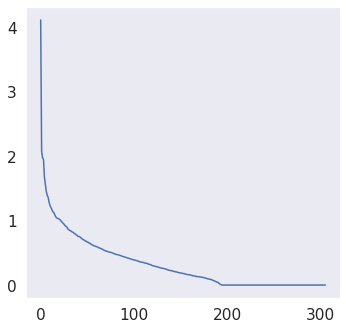

In [ ]:
plt.plot(var_exp)

> Explained Variance Ratio : 각각의 주성분 벡터가 이루는 축에 투영(projection)한 결과의 분산의 비율 (=각 eigenvalue 의 비율)

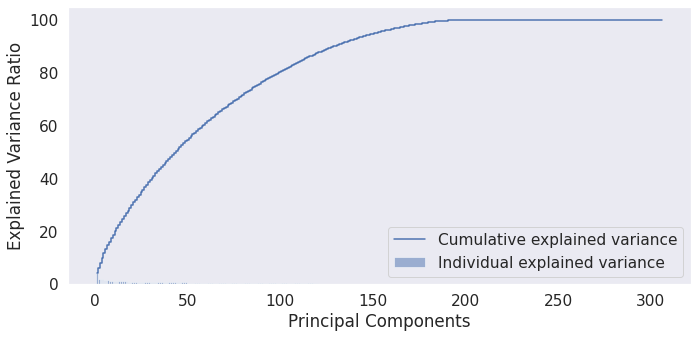

In [ ]:
# Ploting plt.figure(figsize=(10 , 5))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [ ]:
len(cum_var_exp)

306

#### 4. Scikit-learn 으로 PCA 적용하기



In [ ]:
# Using scikit learn PCA here. It does all the above steps and maps data to PCA dimensions in one shot
from sklearn.decomposition import PCA

pca = PCA(n_components=130)
data_reduced = pca.fit_transform(x)
data_reduced.transpose()

array([[ 3.26185530e+00,  1.81271583e+00,  2.21584774e+00, ...,
        -5.38609106e+00, -4.57167395e+00, -5.28922071e+00],
       [ 8.02740411e-02,  8.46124806e-01,  2.62168329e-01, ...,
         3.48970706e+01,  4.06170531e+00,  3.53853029e+01],
       [-2.10776153e-01, -9.59635575e-01, -1.19335555e+00, ...,
         3.05928007e+00,  2.00055695e+00,  5.14369865e+00],
       ...,
       [ 3.48533788e-01,  9.79191517e-01,  1.60578846e+00, ...,
        -1.76777358e+00, -1.71207916e+00, -1.15413158e+00],
       [ 4.76065747e-01, -1.51933838e-02, -1.31544085e+00, ...,
         1.69044513e-01, -1.43477866e+00,  7.74078029e-01],
       [ 5.49320689e-01,  7.65413776e-01,  6.64360315e-01, ...,
        -1.13911642e-01, -8.65753828e-02,  2.73992242e-01]])

In [ ]:
pca.components_

array([[-0.02536958, -0.00257884,  0.02753414, ..., -0.04853596,
         0.01242543,  0.0256921 ],
       [-0.00865567,  0.00538325,  0.00681411, ..., -0.05395307,
         0.02265702,  0.06086481],
       [-0.00303253, -0.03440813, -0.01400089, ..., -0.04823986,
         0.00838185,  0.04287396],
       ...,
       [-0.00189488, -0.00119501, -0.03026142, ..., -0.05406313,
        -0.04904959,  0.07622787],
       [-0.07246352, -0.10956535,  0.05747532, ..., -0.04811269,
        -0.12927101,  0.09221146],
       [-0.10044129, -0.04109729, -0.0365206 , ...,  0.00801966,
         0.04940298,  0.04174046]])

In [ ]:
df_comp = pd.DataFrame(pca.components_,columns=list(x))
df_comp.head()

,0,1,2,3,4,8,9,10,11,13,14,15,16,19,20,21,23,24,25,28,29,31,32,33,36,40,41,42,45,47,52,53,59,60,62,63,64,67,71,72,...,506,507,508,509,510,511,512,513,514,515,521,528,529,530,531,532,533,534,535,536,537,538,542,543,544,546,551,558,559,562,565,570,571,572,578,582,583,586,587,589
0,-0.025370,-0.002579,0.027534,-0.066608,-0.024699,0.077981,-0.031003,0.017991,-0.011328,4.499663e-21,0.005033,0.019391,0.027701,-0.039516,-0.050304,-0.052859,0.016272,0.058626,-0.202494,-0.190198,0.123875,0.167173,0.027159,0.043980,-0.005828,-0.056705,0.039729,-0.007907,-0.047040,-0.008641,8.178116e-21,0.001017,0.171374,0.009456,-0.011423,0.082010,0.013754,0.049314,-0.111448,0.097096,...,0.0,0.0,0.0,0.0,0.129524,0.019606,0.0,0.0,0.0,0.0,0.003645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.101994,-0.128223,0.091798,-0.026988,0.000649,-0.023091,-0.012600,-0.167819,-0.103563,-0.017317,0.095065,-0.020350,-0.006380,-0.012915,0.006665,-0.048536,0.012425,0.025692
1,-0.008656,0.005383,0.006814,0.043182,0.000091,-0.217424,0.002427,0.042956,-0.307618,-1.182786e-18,-0.038287,-0.288472,-0.076216,-0.020928,-0.004805,0.031167,-0.012396,-0.012609,-0.061741,-0.043705,0.033974,0.008654,-0.018982,-0.020478,-0.003104,0.001475,-0.009732,0.009798,-0.001829,0.015762,-7.431893e-19,-0.013670,0.004985,-0.001838,-0.035266,0.063348,0.080935,0.004046,0.025802,0.016825,...,-0.0,-0.0,-0.0,-0.0,0.053832,-0.024922,-0.0,-0.0,-0.0,-0.0,0.017049,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.012442,-0.000423,0.007629,-0.011564,0.008844,0.018328,0.007624,0.014051,0.013687,-0.015342,0.029585,0.013737,0.039335,0.006927,0.006354,-0.053953,0.022657,0.060865
2,-0.003033,-0.034408,-0.014001,-0.003739,-0.003485,-0.062299,-0.011087,-0.037443,-0.033605,2.125768e-18,0.063051,-0.013860,0.017506,0.059024,-0.056334,-0.169485,-0.036789,0.044893,0.021636,0.064322,0.022334,0.130557,0.026914,0.040929,-0.026179,0.033886,-0.015744,0.056901,0.173766,-0.064407,8.716347e-19,0.033252,0.062353,0.133052,0.315843,0.102868,0.058527,0.270844,0.009616,-0.039071,...,0.0,0.0,0.0,0.0,-0.074749,0.040378,0.0,0.0,0.0,0.0,0.004301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003128,-0.003032,-0.013513,0.027575,-0.005281,0.039686,0.011634,-0.026315,-0.032973,-0.007388,-0.011177,-0.008236,-0.029706,-0.048940,0.013379,-0.048240,0.008382,0.042874
3,-0.011012,0.019495,0.031015,0.008150,0.037436,0.027087,-0.034177,0.030426,0.011600,2.068046e-18,-0.042480,0.037251,-0.026755,-0.024962,0.054694,0.244291,0.026842,-0.096052,0.082803,-0.059803,-0.053261,-0.253414,0.031541,0.045053,-0.030383,-0.073183,0.015126,0.020209,0.034119,0.111893,-3.261840e-19,-0.014763,0.170914,0.060264,0.130654,0.300692,0.170088,0.269138,0.016507,0.072268,...,-0.0,-0.0,-0.0,-0.0,0.118447,0.015976,-0.0,-0.0,-0.0,-0.0,0.003134,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.003925,0.046982,0.030228,-0.006041,0.033544,-0.039091,-0.000985,0.033709,0.042442,-0.031512,-0.018136,0.031904,0.048758,0.010024,0.018019,0.021471,-0.018803,-0.007800
4,-0.001612,-0.024110,-0.050005,-0.037773,-0.030998,0.003801,-0.003772,-0.000668,-0.092508,-2.786955e-18,-0.133610,-0.108133,-0.019031,0.042282,0.032290,-0.052566,-0.015691,0.017754,0.103905,0.053301,-0.100591,-0.011657,0.002331,-0.015172,-0.008584,0.012027,0.002234,-0.041104,-0.113296,0.091881,1.730742e-18,-0.000727,-0.021028,-0.080188,-0.039069,0.014701,-0.105293,0.046534,-0.090471,0.013501,...,0.0,0.0,0.0,0.0,-0.049405,-0.012687,0.0,0.0,0.0,0.0,-0.037832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.013370,0.019758,0.060036,-0.057715,-0.064307,-0.053675,-0.056208,-0.080534,-0.051726,-0.022409,0.033647,0.025760,-0.102885,-0.021630,-0.015484,0.035708,-0.088354,-0.083100


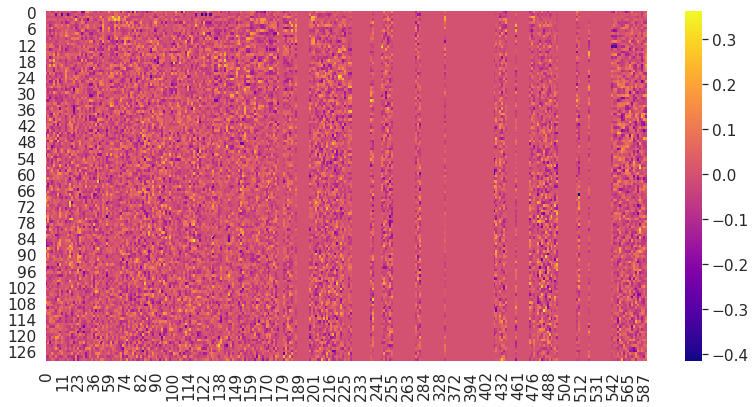

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

> PCA 적용된 데이터 탐색

In [ ]:
data_reduced.shape

(1567, 130)

In [ ]:
df_red2 = pd.DataFrame(data_reduced)
df_red2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129
0,3.261855,0.080274,-0.210776,-0.872210,-0.618955,0.753783,-0.013408,-0.573144,-3.189641,1.889459,2.998541,-1.026346,-3.657220,-1.863641,0.021561,-0.185935,0.252711,3.306128,-0.086783,2.139185,0.540979,-1.611395,0.391576,-1.899909,0.781288,-0.306475,-0.728202,0.648528,1.529418,-1.375453,-2.408452,-0.106925,1.328540,-1.354272,0.862228,-2.580008,1.682560,2.079733,-2.339487,-3.127573,...,0.287819,0.625365,0.648420,0.421466,0.086000,-0.570081,-0.613877,0.377984,-1.260441,0.394755,0.184474,0.199082,-0.793669,1.363900,-0.307182,-1.233594,0.558205,1.263092,0.305966,-0.637887,0.721950,0.835279,-0.551220,1.075978,-0.346815,-0.379226,0.677068,-0.066131,-0.864088,0.294204,0.304095,-0.486536,0.018647,-0.733866,0.806358,0.214923,0.123524,0.348534,0.476066,0.549321
1,1.812716,0.846125,-0.959636,-0.070682,0.165175,0.658556,-1.083161,0.301295,-2.559513,1.301731,0.133987,0.023357,-0.411541,-1.814726,-0.790721,-0.649431,-0.620984,0.281134,-0.455430,-2.468004,1.884304,-0.655962,2.706700,-1.817946,-0.163483,0.957975,0.047809,1.081055,0.198586,0.509598,-0.715593,-0.277992,-1.025682,1.464237,0.372389,0.849599,-0.081582,0.037780,0.836019,-1.150427,...,1.282305,-0.083806,2.239443,1.370149,-1.613546,-0.407196,0.944383,0.359972,-0.362303,2.542229,-0.931776,-0.359479,-0.691235,0.141523,0.095656,0.851078,0.935757,-0.492662,-0.034945,0.170669,-0.149958,-0.326494,-0.642452,-1.327520,0.596019,-0.235253,-0.627243,-1.516122,-1.488372,0.763493,-0.778931,-0.064869,0.407564,0.488577,-0.389793,-0.349300,0.013539,0.979192,-0.015193,0.765414
2,2.215848,0.262168,-1.193356,2.265481,-1.239638,-0.951533,2.023563,0.905879,-1.154482,-1.811241,0.243033,-1.050987,-1.743444,-1.988547,-0.195948,-1.196417,-0.631498,1.513607,-0.330026,-2.439655,-2.559528,-0.651959,-2.024321,-1.184865,1.508668,-0.758372,-2.362427,-0.488730,3.162333,-1.204024,-0.963798,4.341801,-1.921684,0.600228,2.099665,1.736197,-0.740704,-2.043784,-0.057593,0.763303,...,-0.131894,-0.051757,-0.253803,1.681563,-0.513233,-0.635872,-0.616213,-0.546773,0.887810,-0.387097,-0.496964,0.844190,0.315321,0.362994,-1.630419,-0.112650,0.052372,-0.231183,0.083445,0.188701,-0.909236,0.246882,0.112231,-1.249599,-1.339265,0.136145,-0.176067,-0.380476,0.697011,-0.104712,-0.800437,0.119947,-0.649393,0.290785,-0.932646,-0.334546,0.668609,1.605788,-1.315441,0.664360
3,3.617137,0.816863,-0.816705,2.151568,-2.612484,-1.409251,1.174620,0.842696,-0.292111,-2.761173,-1.365109,3.246901,-0.936567,-2.733917,-0.280698,-1.535594,-4.791352,2.026011,0.099395,-3.896041,-0.931304,2.792762,1.510323,-1.077488,3.012306,-1.527358,0.313822,4.701211,2.910656,-2.043701,-1.097733,3.622274,-2.470132,-2.776865,4.375927,3.480783,-1.045409,-3.289005,2.434698,-2.487666,...,1.221420,-1.641392,-3.093512,-1.981050,3.170024,0.548839,-2.197157,1.027407,0.724643,1.182206,-1.002865,-1.190588,-2.099073,-3.300863,-2.539381,0.888892,-0.502819,0.731684,4.273941,-1.294079,2.669040,1.777487,-0.601735,-1.655639,4.310778,2.823397,0.940826,-3.785153,4.450786,-2.071992,2.789457,-0.113403,4.939324,2.130922,-0.624369,0.947140,-0.055644,-1.219752,-0.320817,-0.190817
4,2.765991,0.134018,1.444436,2.270237,-1.497950,-0.624068,-2.929937,-1.896202,2.506050,1.484131,0.854550,0.165184,-0.599797,-2.911034,-0.807686,-0.559749,-5.659308,0.559660,-0.351049,-2.106578,-0.915566,-1.790618,1.612312,4.613230,-3.282610,-1.439798,2.349581,1.880206,1.328514,-4.261796,-1.718110,-1.574710,0.500028,-0.680078,-2.652722,3.601054,-0.796614,1.076042,-0.995845,-3.889267,...,-0.792428,0.579724,-1.310998,-0.639991,-2.481142,-1.271978,4.782747,-2.925582,-0.540236,-1.138650,-0.165617,-2.366104,-2.024749,1.423193,0.163762,-2.363259,-0.231445,1.224052,0.284352,-0.751221,-0.994802,-1.351660,0.677269,1.019055,-0.488845,1.192307,-0.945999,1.578403,0.9

> Pass/Fail 데이터 합치기

In [ ]:
df_red3 = df_red2.copy()
df_red4 = df_red3
df_red4["Pass/Fail"] = data["Pass/Fail"]

In [ ]:
df_red4.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,Pass/Fail
0,3.261855,0.080274,-0.210776,-0.872210,-0.618955,0.753783,-0.013408,-0.573144,-3.189641,1.889459,2.998541,-1.026346,-3.657220,-1.863641,0.021561,-0.185935,0.252711,3.306128,-0.086783,2.139185,0.540979,-1.611395,0.391576,-1.899909,0.781288,-0.306475,-0.728202,0.648528,1.529418,-1.375453,-2.408452,-0.106925,1.328540,-1.354272,0.862228,-2.580008,1.682560,2.079733,-2.339487,-3.127573,...,0.625365,0.648420,0.421466,0.086000,-0.570081,-0.613877,0.377984,-1.260441,0.394755,0.184474,0.199082,-0.793669,1.363900,-0.307182,-1.233594,0.558205,1.263092,0.305966,-0.637887,0.721950,0.835279,-0.551220,1.075978,-0.346815,-0.379226,0.677068,-0.066131,-0.864088,0.294204,0.304095,-0.486536,0.018647,-0.733866,0.806358,0.214923,0.123524,0.348534,0.476066,0.549321,-1
1,1.812716,0.846125,-0.959636,-0.070682,0.165175,0.658556,-1.083161,0.301295,-2.559513,1.301731,0.133987,0.023357,-0.411541,-1.814726,-0.790721,-0.649431,-0.620984,0.281134,-0.455430,-2.468004,1.884304,-0.655962,2.706700,-1.817946,-0.163483,0.957975,0.047809,1.081055,0.198586,0.509598,-0.715593,-0.277992,-1.025682,1.464237,0.372389,0.849599,-0.081582,0.037780,0.836019,-1.150427,...,-0.083806,2.239443,1.370149,-1.613546,-0.407196,0.944383,0.359972,-0.362303,2.542229,-0.931776,-0.359479,-0.691235,0.141523,0.095656,0.851078,0.935757,-0.492662,-0.034945,0.170669,-0.149958,-0.326494,-0.642452,-1.327520,0.596019,-0.235253,-0.627243,-1.516122,-1.488372,0.763493,-0.778931,-0.064869,0.407564,0.488577,-0.389793,-0.349300,0.013539,0.979192,-0.015193,0.765414,-1
2,2.215848,0.262168,-1.193356,2.265481,-1.239638,-0.951533,2.023563,0.905879,-1.154482,-1.811241,0.243033,-1.050987,-1.743444,-1.988547,-0.195948,-1.196417,-0.631498,1.513607,-0.330026,-2.439655,-2.559528,-0.651959,-2.024321,-1.184865,1.508668,-0.758372,-2.362427,-0.488730,3.162333,-1.204024,-0.963798,4.341801,-1.921684,0.600228,2.099665,1.736197,-0.740704,-2.043784,-0.057593,0.763303,...,-0.051757,-0.253803,1.681563,-0.513233,-0.635872,-0.616213,-0.546773,0.887810,-0.387097,-0.496964,0.844190,0.315321,0.362994,-1.630419,-0.112650,0.052372,-0.231183,0.083445,0.188701,-0.909236,0.246882,0.112231,-1.249599,-1.339265,0.136145,-0.176067,-0.380476,0.697011,-0.104712,-0.800437,0.119947,-0.649393,0.290785,-0.932646,-0.334546,0.668609,1.605788,-1.315441,0.664360,1
3,3.617137,0.816863,-0.816705,2.151568,-2.612484,-1.409251,1.174620,0.842696,-0.292111,-2.761173,-1.365109,3.246901,-0.936567,-2.733917,-0.280698,-1.535594,-4.791352,2.026011,0.099395,-3.896041,-0.931304,2.792762,1.510323,-1.077488,3.012306,-1.527358,0.313822,4.701211,2.910656,-2.043701,-1.097733,3.622274,-2.470132,-2.776865,4.375927,3.480783,-1.045409,-3.289005,2.434698,-2.487666,...,-1.641392,-3.093512,-1.981050,3.170024,0.548839,-2.197157,1.027407,0.724643,1.182206,-1.002865,-1.190588,-2.099073,-3.300863,-2.539381,0.888892,-0.502819,0.731684,4.273941,-1.294079,2.669040,1.777487,-0.601735,-1.655639,4.310778,2.823397,0.940826,-3.785153,4.450786,-2.071992,2.789457,-0.113403,4.939324,2.130922,-0.624369,0.947140,-0.055644,-1.219752,-0.320817,-0.190817,-1
4,2.765991,0.134018,1.444436,2.270237,-1.497950,-0.624068,-2.929937,-1.896202,2.506050,1.484131,0.854550,0.165184,-0.599797,-2.911034,-0.807686,-0.559749,-5.659308,0.559660,-0.351049,-2.106578,-0.915566,-1.790618,1.612312,4.613230,-3.282610,-1.439798,2.349581,1.880206,1.328514,-4.261796,-1.718110,-1.574710,0.500028,-0.680078,-2.652722,3.601054,-0.796614,1.076042,-0.995845,-3.889267,...,0.579724,-1.310998,-0.639991,-2.481142,-1.271978,4.782747,-2.925582,-0.540236,-1.138650,-0.165617,-2.366104,-2.024749,1.423193,0.163762,-2.363259,-0.231445,1.224052,0.284352,-0.751221,-0.994802,-1.351660,0.677269,1.019055,-0.488845,1.192307,-0.945999,1.578403,0.957879,2.225327,-1.345235,-0.2

In [ ]:
df_red4.shape

(1567, 131)

#### 5. 이상치 제거

> Pass/Fail 별 PCA 데이터의 이상치 탐색

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8eed448910>,
      dtype=object)

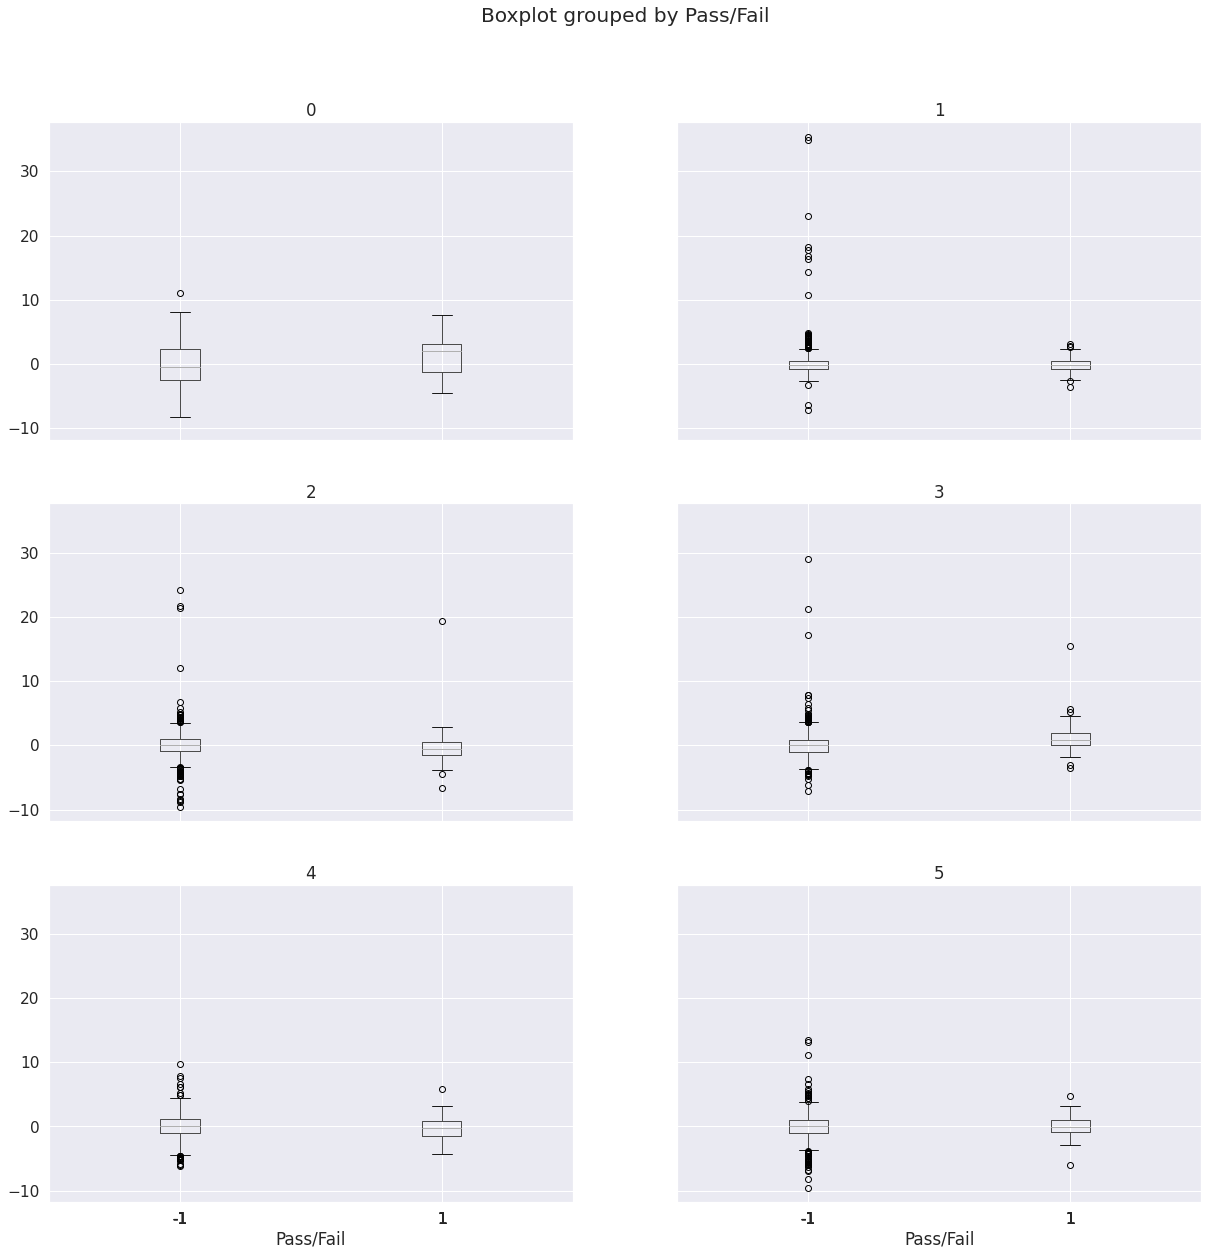

In [ ]:
df_red4.boxplot(column = [df_red4.columns[0],
                          df_red4.columns[1],
                          df_red4.columns[2],
                          df_red4.columns[3], 
                          df_red4.columns[4],
                          df_red4.columns[5],
                         ]
                          , by = 'Pass/Fail', figsize=(20,20))

> 이상치 제거 적용 (Quantile, IQR 사용)

In [ ]:
pd_data = df_red4.copy()

from scipy import stats

def outlier_removal_max(var):
    var = np.where(var > var.quantile(0.75)+ stats.iqr(var),var.quantile(0.50),var)
    return var

def outlier_removal_min(var):
    var = np.where(var < var.quantile(0.25) - stats.iqr(var),var.quantile(0.50),var)
    return var

for column in pd_data:
    pd_data[column] = outlier_removal_max(pd_data[column])
    pd_data[column] = outlier_removal_min(pd_data[column])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8eed0addd0>,
      dtype=object)

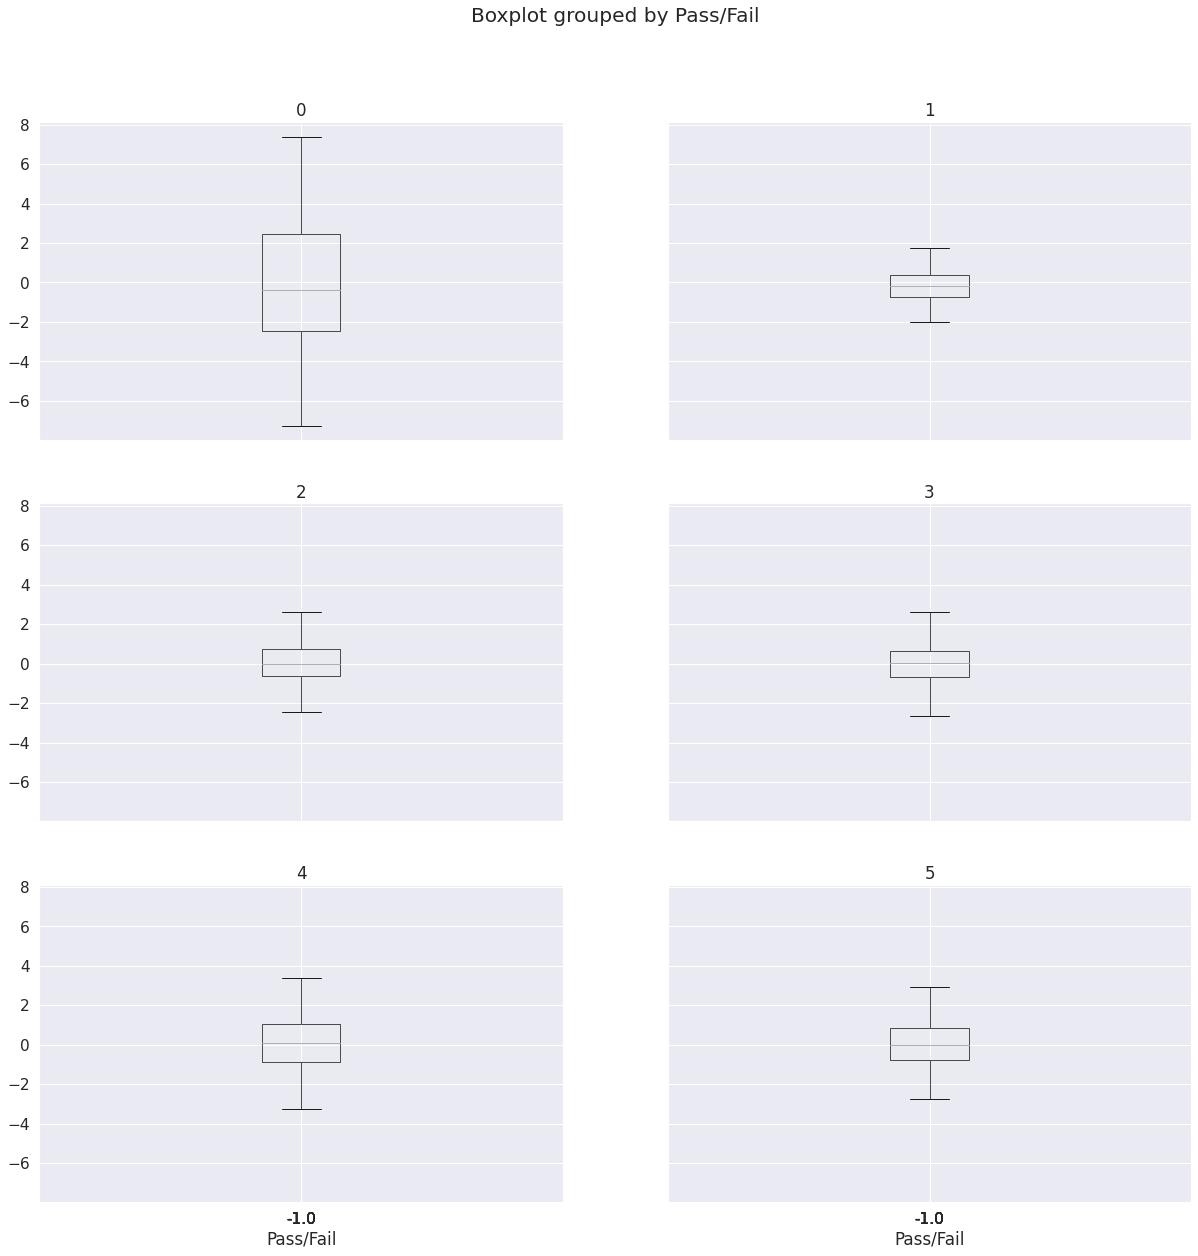

In [ ]:
pd_data.boxplot( column =[df_red4.columns[0],
                          df_red4.columns[1],
                          df_red4.columns[2],
                          df_red4.columns[3], 
                          df_red4.columns[4],
                          df_red4.columns[5],
                         ],by = 'Pass/Fail', figsize=(20,20))

### 6) PCA 적용+이상치 제거 데이터 재모델링

#### 1. 언더샘플링


In [ ]:
x = df_red4.iloc[:, df_red4.columns != 'Pass/Fail'] 
y = df_red4.iloc[:, df_red4.columns == 'Pass/Fail']

print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 130)
shape of y: (1567, 1)


In [ ]:
failed_tests = np.array(df_red4[df_red4['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

104


In [ ]:
normal_indices = df_red4[df_red4['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

1463


In [ ]:
random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

104


In [ ]:
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [ ]:
undersample_data = df_red4.iloc[under_sample, :]

x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(208, 130)
(208, 1)


In [ ]:
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(145, 130)
(145, 1)
(63, 130)
(63, 1)


#### 1. XGBoost-PCA (Undersampled 데이터)

In [ ]:
model = XGBClassifier(random_state=1)
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


> Confusion Matrix

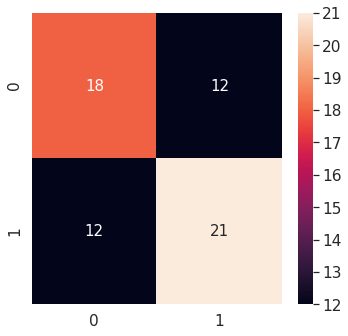

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [ ]:
print("Accuracy: ", model.score(x_test_us,y_test_us)*100)

Accuracy:  61.904761904761905


#### 2. Grid Search - XGBoost - PCA (Undersampled 데이터)

In [ ]:
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
             'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', n_jobs = -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: ", best_accuracy*100)
print("Best Parameter: ", best_parameters)

Best Accuracy:  59.310344827586206
Best Parameter:  {'cv': 2, 'max_depth': 4, 'random_state': 1}


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
weights = (y == 0).sum()/(1.0*(y == -1).sum())

model = XGBClassifier(max_depth = 4, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

print("Accuracy: ", model.score(x_test_us,y_test_us)*100)

Accuracy:  58.730158730158735


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


> Confusion Matrix

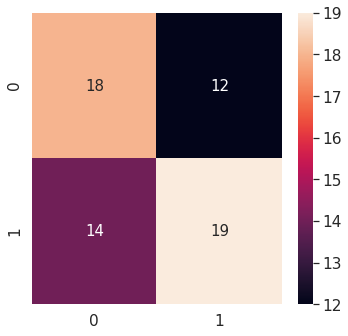

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

#### 3. Random Forest - PCA (Undersampled 데이터)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


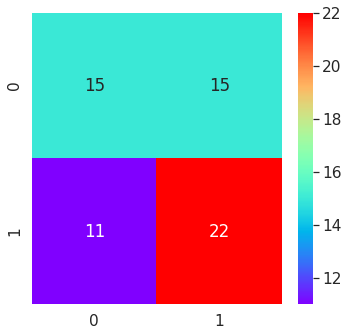

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [ ]:
print("Accuracy: ", model.score(x_test_us,y_test_us)*100)

Accuracy:  58.730158730158735


#### 3. Logistic Regression - PCA (Undersampled 데이터)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


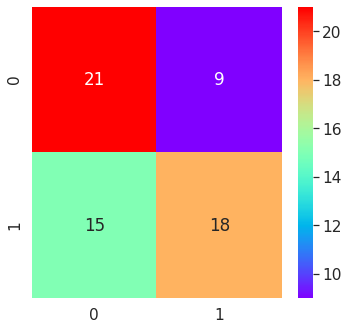

In [ ]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_us, y_train_us) 
y_pred = lr.predict(x_test_us)

cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [ ]:
print("Accuracy: ", lr.score(x_test_us,y_test_us)*100)

Accuracy:  61.904761904761905


#### 4. Lasso - PCA (Undersampled 데이터)

In [ ]:
lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train_us,y_train_us)

y_pred = lasso.predict(x_test_us)

y_pred2 = np.sign(y_pred)

In [ ]:
actual_cost = list(y_test_us)
actual_cost = np.asarray(actual_cost)
y_pred_lass = lasso.predict(x_test_us)

In [ ]:
print("Accuracy: ", lasso.score(x_test_us, y_test_us)*100)

Accuracy:  4.716336315156832


> Confusion Matrix

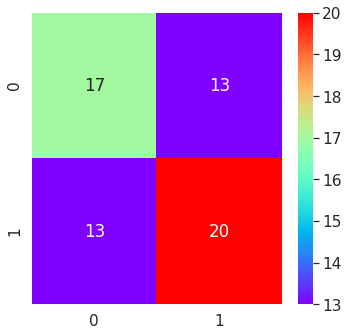

In [ ]:
cm = confusion_matrix(y_test_us, y_pred2)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

### Feature Importances

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()
model.fit(x_train_us, y_train_us)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pio.renderers
pio.renderers.default = 'colab'
pio.renderers

trace = go.Scatter(
    y = model.feature_importances_,
    x = x_train_us.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = model.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = x_train_us.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Model Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter')